# Analiza związków między danymi dotyczącymi ludności, pożarów, nowych mieszkań i zezwoleń na handel alkoholem

W poniższej analizie przyjrzymy się zależnościom między wymienionymi statystykami oraz zinterpretujemy wyniki. Niektóre hipotezy na temat korelacji tych danych są łatwe do wysnucia np. przypuszczalnie więcej pożarów występuje na bardziej zaludnionych obszarach. Sprawdzimy tego typu hipotezy, ale co ważniejsze na podstawie danych poszukamy głębiej ukrytych mechanizmów wpływania jednych czynników na inne. Będziemy korzystać z paczki którą przygotowałem w ramach tego projektu. Ale najpierw przygotujmy elementy potrzebne do analiz.

# Importy

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import pandas as pd

'import argparse\nimport os\nimport sys \nimport matplotlib.pyplot as plt\nimport pytest\nimport cProfile\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.metrics import r2_score\nimport numpy as np\nimport math'

In [25]:
from src.project_analiza_Szymon.io_utils.read import load_data_from_folder
import src.project_analiza_Szymon.preprocessing as prep
import src.project_analiza_Szymon.calculate as clc
import src.project_analiza_Szymon.plots as pl
from src.project_analiza_Szymon.io_utils.write import *

# Ładowanie danych

Teraz załadujemy dane za pomocą stworzonej funkcji. Wypisujemy nazwy plików dla czytelności.

In [26]:
datasets = load_data_from_folder("data")

Reading: data\C1.xlsx
Reading: data\nowe_mieszkania.xlsx
Reading: data\powierzchnia_i_ludnosc_w_przekroju_terytorialnym_w_2024_roku_tablice.xlsx
Reading: data\raport_na_dzien_1_września_2023_r.csv
Reading: data\raport_zezwoleń_czynnych_na_dzień_2_września_2024_r.csv


# preprocessing

W tym rozdziale przeprowadzamy przetwarzanie danych, w celu zapewnienia użytkowników i kompletności danych oraz ich jakości wypisujemy
wyczerpującą informację o brakach danych i o tym czy zostały usunięte pewne rekordy.

In [27]:
pozary_grup_pw = prep.pozary_powiat(datasets[0][1])
pozary_grup_woj = prep.pozary_woj(datasets[0][1])
lud_pow_woj = prep.ludn_woj(datasets[2][1])
koncesje_hurt = prep.koncesje(datasets[5][1])
koncesje_2023 = prep.koncesje(datasets[4][1])

brak na
 Ogółem zdarzeń rok 2024          0
Pożary rok 2024                  0
Miejscowe zagrożenia rok 2024    0
powiat                           0
dtype: int64
brak na
 Ogółem zdarzeń rok 2024          0
Pożary rok 2024                  0
Miejscowe zagrożenia rok 2024    0
Województwo                      0
dtype: int64
brak na
 Województwo            0
powierzchnia w km^2    0
Ludność ogółem         0
Ludność na km^2        0
dtype: int64
brak na
 liczba_zezwolen    0
Województwo        0
dtype: int64
brak na
 liczba_zezwolen    0
Województwo        0
dtype: int64


In [28]:
mieszk = prep.nowe_mieszkania(datasets[1][1])


Są wszystkie woj: 16
brak na
 Województwo             0
nowe_mieszkania_2023    0
nowe_mieszkania_2024    0
dtype: int64


In [29]:
pozary_2023 = prep.pozary_wczesniej(datasets[0][1])
ludn_pow_2024_pow = prep.ludn_powiat(datasets[3][1])

df_ludn_poz = prep.lacz_ludn_pozar(ludn_pow_2024_pow, pozary_grup_pw)

brak na
 Pożary rok 2023    0
Województwo        0
dtype: int64
w danych są przerwy np.             powiaty powierzchnia w km^2 Ludność ogółem      Ludność na km^2
0               NaN       w km²\nin km²  ogółem\ntotal  na 1 km²\nper 1 km²
1               NaN                 NaN            NaN                  NaN
2          Powiaty:                 NaN            NaN                  NaN
3          Powiats:                 NaN            NaN                  NaN
4     bolesławiecki                1303          87642                   67
liczby braków w kol.: powiaty                0
powierzchnia w km^2    4
Ludność ogółem         4
Ludność na km^2        4
dtype: int64
braki są w tych samych wierszach: 
powierzchnia : Index([190, 191, 304, 305], dtype='int64')
ludnosc ogolem: Index([190, 191, 304, 305], dtype='int64')
Ludność na km^2 : Index([190, 191, 304, 305], dtype='int64')
                        powiaty powierzchnia w km^2 Ludność ogółem  \
190   Miasto na prawach powiatu       

In [30]:
df_lud_zez_poz = prep.lacz_trzy(lud_pow_woj, koncesje_hurt, pozary_grup_woj)

braki: Województwo                      0
powierzchnia w km^2              0
Ludność ogółem                   0
Ludność na km^2                  0
liczba_zezwolen                  0
Ogółem zdarzeń rok 2024          0
Pożary rok 2024                  0
Miejscowe zagrożenia rok 2024    0
dtype: int64


Warto podkreślić, że nie było żadnych strat rekordów podczas preprocessingu, braki danych wynikały głównie z niejednolitych postaci tabel zawierających m.in. przerwy  
w tabeli i niespójności w pisowni w przypadku zmiennych kategoryjnych.

# Zależności między zaludnieniem a liczbą pożarów oraz zaludnieniem a liczbą zezwoleń na hurtowy handel alkoholami

Teraz zajmiemy się kwestią wpływu liczby ludności na pożary oraz na handel alkoholem. Oczywiście można podejrzewać że wraz z większym zaludnieniem handel  
(w szczególności hurtowy handel alkoholem) zwiększa się, a także, że wystąpienia pożarów też są częstsze ze względu na więcej potencjalnych miejsc gdzie mogą wystąpić (głównie płoną budynki), a także błędy ludzi. Najpierw przyjrzyjmy się podstawowym informacją dotyczącym tych danych.

In [31]:
print(f'najwięcej pożarów (liczba, powiat): {clc.simple_stat(df_ludn_poz["Pożary rok 2024"], df_ludn_poz.powiat)[0][0]}, {clc.simple_stat(df_ludn_poz["Pożary rok 2024"], df_ludn_poz.powiat)[0][1]}')
print(f'największa ludność (liczba, powiat): {clc.simple_stat(df_ludn_poz["Ludność ogółem"], df_ludn_poz.powiat)[0][0]}, {clc.simple_stat(df_ludn_poz["Ludność ogółem"], df_ludn_poz.powiat)[0][1]}')
print(f'najwięcej koncesji (liczba, województwo): {clc.simple_stat(koncesje_hurt["liczba_zezwolen"], koncesje_hurt["Województwo"])[0][0]}, {clc.simple_stat(koncesje_hurt["liczba_zezwolen"], koncesje_hurt["Województwo"])[0][1]}')

print(f'min, średnia i mediana liczby pożarów: {clc.simple_stat(df_ludn_poz["Pożary rok 2024"], df_ludn_poz.powiat)[1][0]}, {clc.simple_stat(df_ludn_poz["Pożary rok 2024"], df_ludn_poz.powiat)[2]}, {clc.simple_stat(df_ludn_poz["Pożary rok 2024"], df_ludn_poz.powiat)[3]}')
print(f'min, średnia i mediana liczby ludności: {clc.simple_stat(df_ludn_poz["Ludność ogółem"], df_ludn_poz.powiat)[1][0]}, {clc.simple_stat(df_ludn_poz["Ludność ogółem"], df_ludn_poz.powiat)[2]}, {clc.simple_stat(df_ludn_poz["Ludność ogółem"], df_ludn_poz.powiat)[3]}')
print(f'min, średnia i mediana liczby zezwoleń: {clc.simple_stat(koncesje_hurt["liczba_zezwolen"], koncesje_hurt["Województwo"])[1][0]}, {clc.simple_stat(koncesje_hurt["liczba_zezwolen"], koncesje_hurt["Województwo"])[2]}, {clc.simple_stat(koncesje_hurt["liczba_zezwolen"], koncesje_hurt["Województwo"])[3]}')


najwięcej pożarów (liczba, powiat): 4251, Warszawa
największa ludność (liczba, powiat): 1861599, Warszawa
najwięcej koncesji (liczba, województwo): 131, mazowieckie
min, średnia i mediana liczby pożarów: 50, 286.63, 218.0
min, średnia i mediana liczby ludności: 18645, 99043.44, 73723.0
min, średnia i mediana liczby zezwoleń: 4, 26.0, 14.0


Te proste statystyki są pierwszą przesłanką, mówiącą o tym że istnieje pewna korelacja. Istotnie, zaobserwujmy, że wartości największe liczby pożarów i ludności występują w tym samym powiecie, natomiast najwięcej zezwoleń na handel alkoholem wydano w naludniejszym województwie (Mazowieckie). Inna własność, na którą warto zwrócić uwagę jest to, że mediana jest mniejsza od śreniej dla każdej z danych. Świadczy to o pewnym podobieństwie między rozkładami tych zmiennych (czyli liczby pożarów w powiatach itd.). Oznacza to też że są regiony gdzie statystyka jest dużo większa w porównaniu z innymi regionami. 

Jeśli korelacja występuje, to warto zbadać jak silna ona jest oraz jaki jest jej rodzaj. W tym celu policzymy współczynniki korelacji liniowej. Najpierw policzmy ją dla danych z powiatów.  

In [32]:
df_ludn_poz[['Pożary rok 2024', "Ludność ogółem"]].corr()

,Pożary rok 2024,Ludność ogółem
Pożary rok 2024,1.000000,0.922357
Ludność ogółem,0.922357,1.000000


Taki współczynnik stanowi o bardzo silnej zależności. Sprawdźmy, czy potwierdzi się to dla danych z poziomu województwa, przy okazji badając korelację z liczbą zezwoleń na handel alkoholem. Dane prezentują się następująco:

In [33]:
df_trzy_dane = df_lud_zez_poz[["Ludność ogółem", "liczba_zezwolen", "Pożary rok 2024"]]
df_trzy_dane.corr()

,Ludność ogółem,liczba_zezwolen,Pożary rok 2024
Ludność ogółem,1.000000,0.877855,0.924436
liczba_zezwolen,0.877855,1.000000,0.873948
Pożary rok 2024,0.924436,0.873948,1.000000


widzimy że współczynniki są bardzo wysokie. Najsilniej skorelowane są liczba pożarów z liczbą ludności, ale pozostałe korelacje są również silne. Pamiętajmy, że dane te nie pochodzą jednak z dużej próby (z województw a jest ich 16), więc są one bardziej wskazówką niż dowodem.  
Do wysunięcia uzasadnionych wniosków potrzebujemy sprawdzić, co jest przyczyną takiej korelacji. Ustaliliśmy już że dodatnia korelacja jest naturalną konsekwencją tego jak działają mechanizmy rynkowe oraz te odpowiadające za powstawanie pożarów, ale na podstawie powyższej tabelki zauważamy coś głębszego. Korelacja między liczbą ludności, a pożarami jest większa od tej między liczbą ludności a liczbą zezwoleń na handel alkoholem. 

Zastanówmy się dlaczego tak jest. korelacja liniowa jest blisko powiązana z modelem liniowym. Przypomnijmy, że wysoka korelacja świadczy o tym, że prosta regresji jest dopasowana do danych i na odwrót, dobre dopasowanie mówi o dużej korelacji w modelu z 1 zmienną objaśniającą. Na wykresach przedstawione jest dopasowanie prostych do danych:

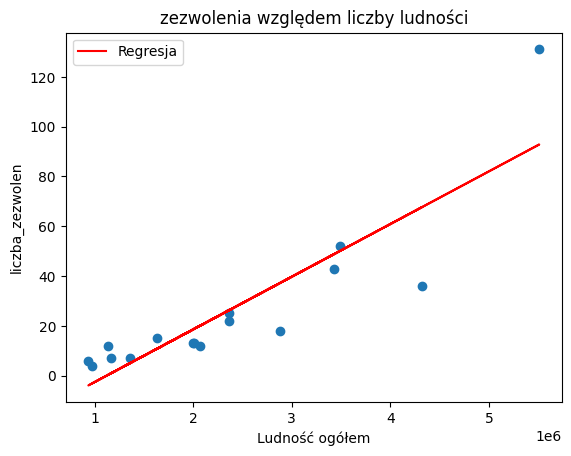

In [34]:
pl.plot_regr_poz_lud(df_lud_zez_poz["Ludność ogółem"], df_lud_zez_poz["liczba_zezwolen"], "Ludność ogółem", "liczba_zezwolen", "zezwolenia względem liczby ludności")

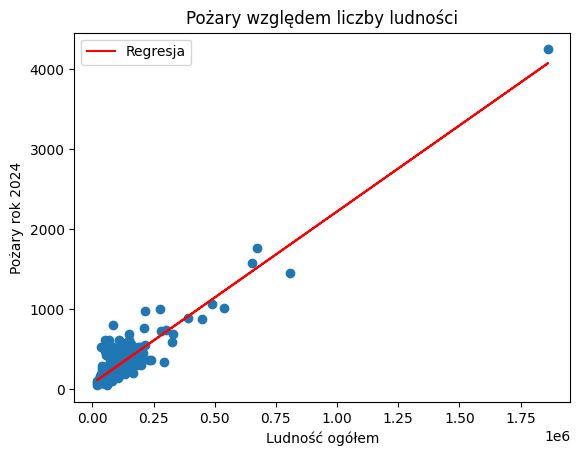

In [35]:
pl.plot_regr_poz_lud(df_ludn_poz["Ludność ogółem"], df_ludn_poz["Pożary rok 2024"])

Widać wyraźnie, że na drugim wykresie prosta bardzo dobrze dopasowała się do danych, natomiast w przypadku pierwszej prostej obserwacje odpowiadające województwom o dużym zaludnieniu nie zostały odpowiednio wyestymowane. Zaledwie trzy województwa zaburzają obraz dobrze dopasowanych danych. To one wpływają na to, że korelacja pierwszej pary danych jest niższa. 

Sprawdźmy czy rzeczywiście możemy uznać te rekordy za oberwacje, które są odstające i mają wpływ na model. Podstawowym statystycznym narzędziem do diagnostyki takich obserwacji są studentyzowane reszty oraz odległość cook'a. Pierwsze są miarą głównie tego jak odstaje obserwacja, ale też zależą od wpływu na model, natomiast kolejne mówi o jej wpływie na model. Obliczając te miary, znajdujemy takie obserwacje, w przypadku regresji liczby zezwoleń względem ludności.

In [36]:
print(df_lud_zez_poz.loc[clc.stat_wplyw_outlier(df_lud_zez_poz["Ludność ogółem"], df_lud_zez_poz["liczba_zezwolen"])[2],\
    ["Województwo", "Ludność ogółem"]])

    Województwo  Ludność ogółem
4   mazowieckie         5510527
14      śląskie         4320130


Odczytując wartość "Ludności ogółem widzimy, że dwie spośród trzech podejrzewanych obserwacji zostały wyznaczone jako wpływowe i odstające. Ich usunięcie rzeczywiście powiększa korelację.

In [37]:
df_lud_zez_poz_out = df_lud_zez_poz.drop([4, 14])
df_lud_zez_poz_out[["Ludność ogółem", "liczba_zezwolen"]].corr()

,Ludność ogółem,liczba_zezwolen
Ludność ogółem,1.000000,0.896092
liczba_zezwolen,0.896092,1.000000


W czternastu pozostałych województwach zależność liniowa dobrze opisuje tą relację. Wydaje się to intuicyjne, ile razy więcej ludzi tyle razy w przybliżeniu większe spożycie alkoholu. Jednak ta analiza jest bardziej subtelna. Po pierwsze kwestie kulturowe i struktury społecznej mogą mieć wpływ na spożycie, a po drugi mówimy o liczbie zezwoleń na sprzedaż, czyli o liczbie dystrybutorów, a nie bezpośrednio o ilości napojów. Mimo to biorąc pod uwagę czternaście województw prosta zależność z dodaną pewną stałą przecięcia prostej z osią Y dobrze opisuje dane, co odpowiada intuicji.

Otwarte jednak pozostaje pytanie dlaczego w tych dwóch województwach ta zależność jest inna. Tego typu pytania otwierają drzwi do kolejnych analiz.  
W tym opracowaniu ograniczę się jednak do hipotez związanych z tym że gęstość zaludnienia, duża liczba miast w sąsiedztwie oraz stosunkowo niewielka powierzchnia umożliwia lepszą dystrybucję alkoholu, co może wpłynąć na mniej firm się tym zajmujących. To przypuszczalnie odpowiada za niewileką liczbę zezwoleń w woj. śląskim. W woj. mazowieckim sytuacja jest odwrotna. 

# liczba zezwoleń, a liczba pożarów

Na początku analiz, w poprzednim punkcie widzieliśmy, że wszystkie trzy dane są powiązane. Dlaczego jest ona tak wysoka między liczbą zezwoleń, a liczbą pożarów? Dlaczego jest nieco mniejsza od innych obliczonych współczynników? Odpowiemy na te pytania. 

Na początek przyjrzyjmy się uważnie trzem wykresom:

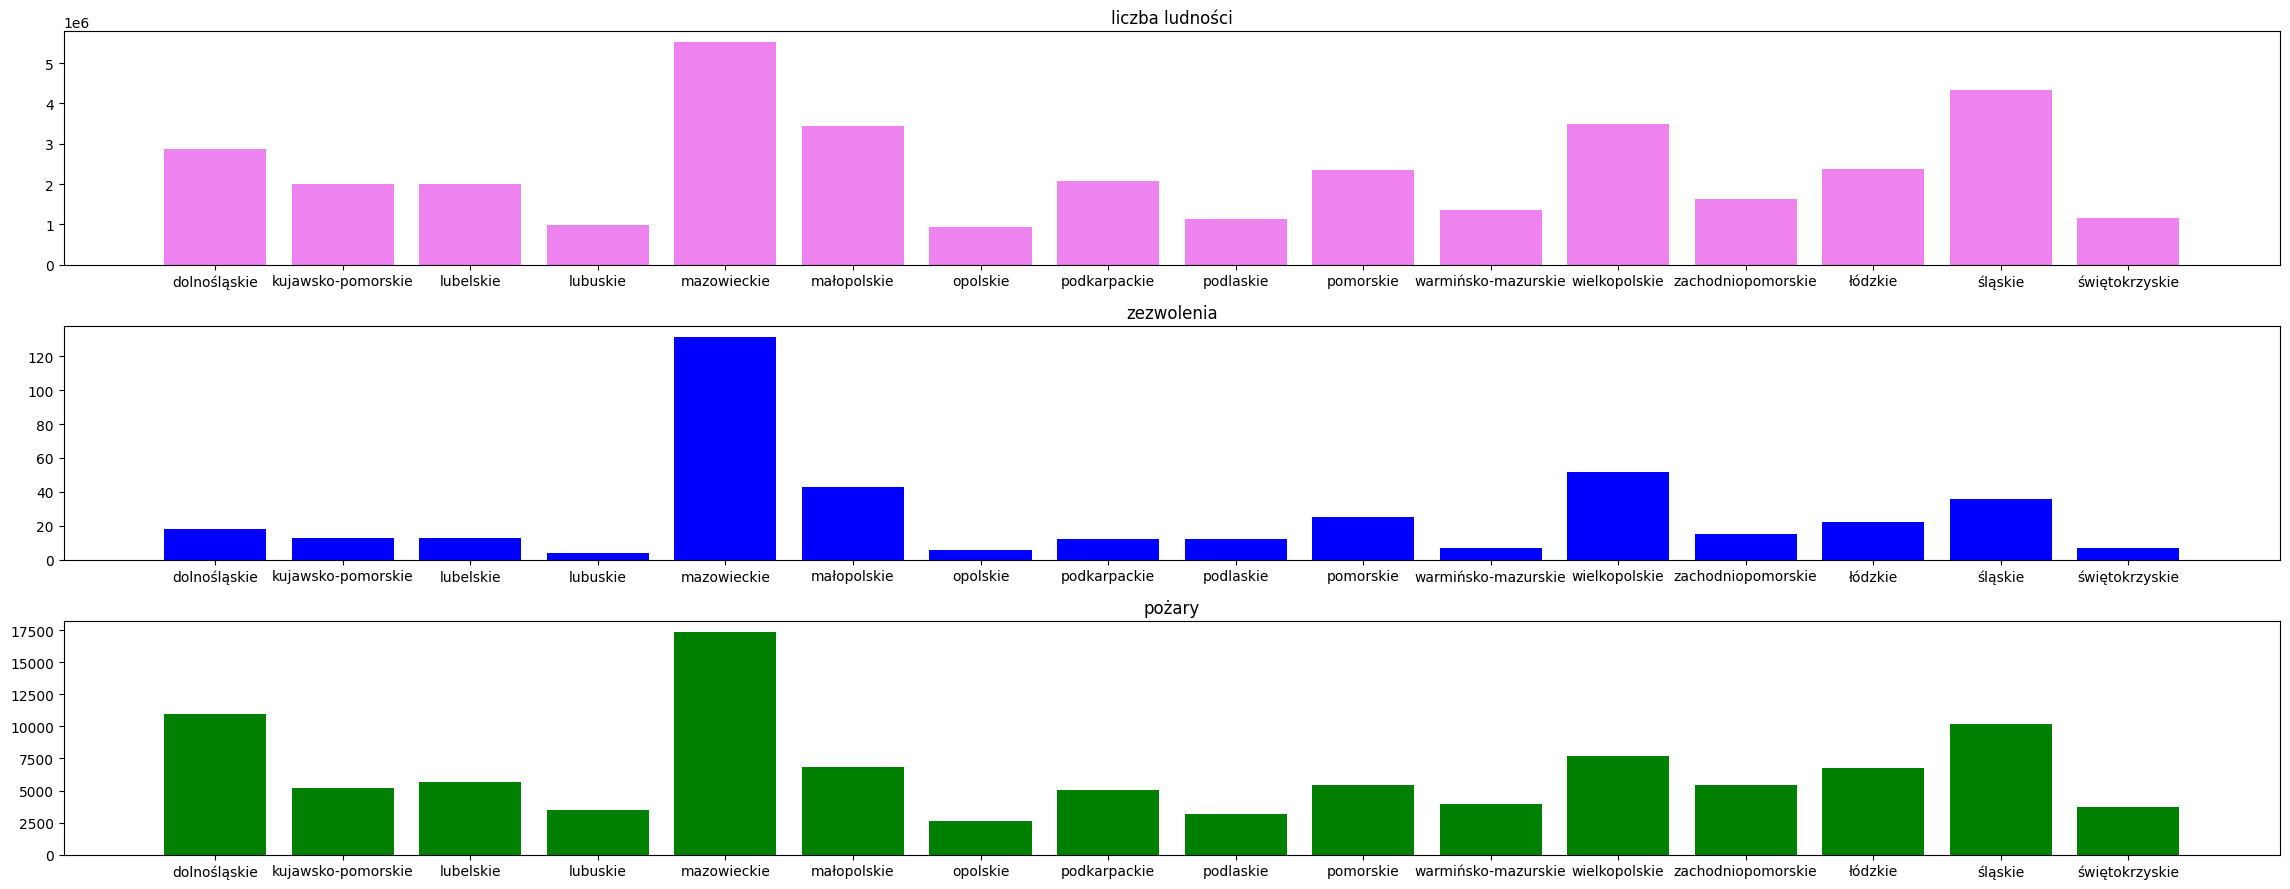

In [38]:
pl.plot_barplots(df_lud_zez_poz['Województwo'], df_lud_zez_poz["Ludność ogółem"], df_lud_zez_poz["liczba_zezwolen"], df_lud_zez_poz["Pożary rok 2024"])

Patrząc na wykresy: zezwoleń i pożarów dostrzegamy podobieństwa, ale rozrzut wartości oraz duże różnice skali zezwoleń i pożarów w niektórych województwach podają w wątpliwość zależność liniową. Z drugiej strony widzimy, że uporząkowanie statystyk jest podobne i województwo z większą ilością pożarów ma też zazwyczaj więcej wydanych zezwoleń na handel alkoholem, co w pewien sposób uzasadnia wysoką korelację. Z tych wizualizacji możemy przekonać się ponadto, że statystyki liczby pożarów i liczby ludności z dobrym przybliżeniem zachowują porządek województw oraz proporcje między wartościami dla poszczególnych z nich. W związku z podobieństwem wykresów pierwszego i trzeciego nasuwa się wątpliwość czy pożary bezpośrednio wpływają na zezwolenia. Przecież możemy mieć zależność od zmiennej ukrytej, mianowicie zarówno pożary jak i zezwolenia mogą zależeć w podobny sposób od zaludnienia i to może być indykatorem zależności.

Zbadamy ten aspekt. W tym celu musimy w pewien sposób zniwelować zmienność liczby ludności która jest dość duża, bo województwa znacznie się różnią pod jej względem. Nasuwającym się podejściem jest bazowanie na danych dotyczących tego samego województwa (np. na danych corocznych dla pojedynczych województw. Możemy dla uproszczenia przyjąć, że liczba mieszkańców jest stała rok do roku. Zobrazujmy jak rokrocznie zmieniały się te statystyki w województwach. Najpierw przeprowadźmy obliczenia.

In [39]:
koncesje_2024 = koncesje_hurt.rename(columns={'liczba_zezwolen': 'liczba_zezwolen_2024'})
koncesje_2023 = koncesje_2023.rename(columns={'liczba_zezwolen': 'liczba_zezwolen_2023'})
zezw_przyr = clc.przyrosty_w_woj(koncesje_2024, koncesje_2023, 'liczba_zezwolen_2024', 'liczba_zezwolen_2023')
poz_przyr = clc.przyrosty_w_woj(pozary_grup_woj ,pozary_2023, "Pożary rok 2024", "Pożary rok 2023")
poz_przyr = poz_przyr.rename(columns={'przyrost': 'przyrost_poz'})
zezw_przyr = zezw_przyr.rename(columns={'przyrost': 'przyrost_zezw'})
por_przyr = pd.merge(poz_przyr, zezw_przyr, on="Województwo")
por_przyr.head()

,przyrost_poz,Województwo,przyrost_zezw
0,1336,dolnośląskie,-5
1,-355,kujawsko-pomorskie,2
2,683,lubelskie,-4
3,73,lubuskie,1
4,1119,mazowieckie,5


Poniżej znajduje się wykres zmian w liczbie zezwoleń i pożarów.

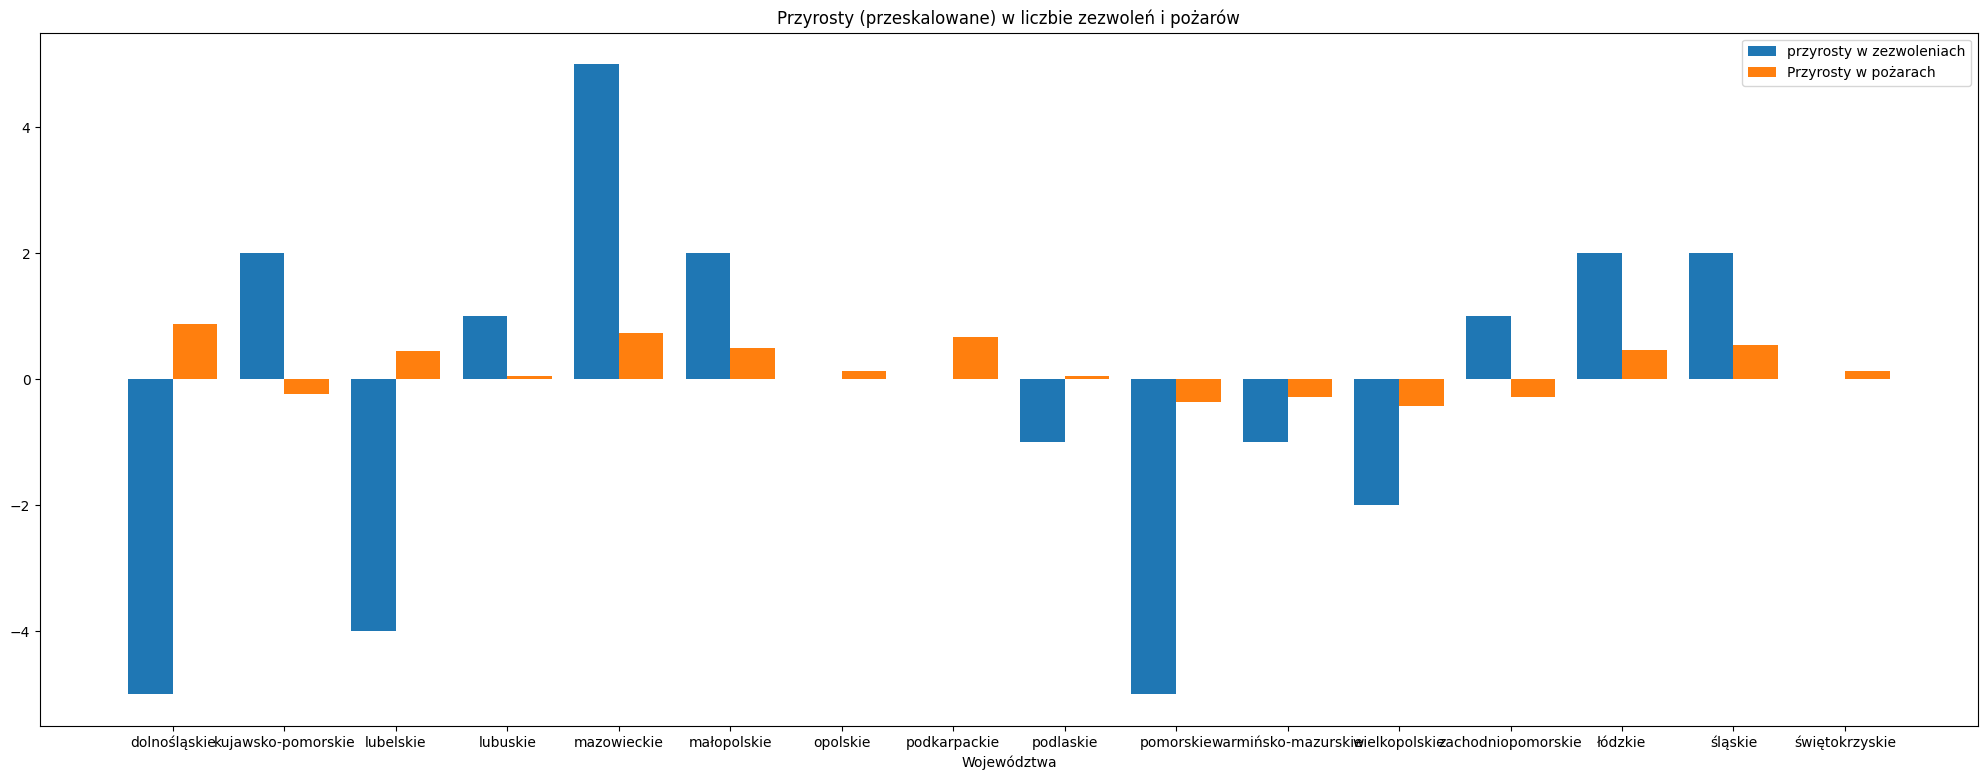

In [40]:
pl.barplot_dwa(por_przyr.przyrost_zezw, por_przyr.przyrost_poz, por_przyr["Województwo"])

Wykres nie pokazuje dużej zależności. W wielu przypadkach zachodzi nawet zależność odwrotna do rozpatrywanej.  

Podsumowując wysoka korelacja w znaczącym stopniu pochodzi od zmiennej ukrytej - liczby ludności, o której wpływie mówiliśmy we wcześniejszym rozdziale. Istnieje wprawdzie podejrzenie, że stan nietrzeźwości wpływa na niebezpieczeństwo pożaru. Jednakże wpływ tego czynnika jest niewielki lub nie wpływa na sprzedawców alkoholu i ich rynek, co pokazuje brak jasnej zależności na wykresie powyżej.

# Temat do wyboru - analiza wpływu oddanych nowych mieszkań na liczbę pożarów

Pozostając w tematyce pożarów, chciałbym zbadać wpływ zabudowy na liczbę pożarów. Łatwymi do znalezienia danymi dotyczącymi zabudowy miejskiej są te dotyczące nowo oddanych do użytkowania mieszkań. Myślę, że te statystyki dobrze wyznaczają miejsca z dużą ilością budynków i zarazem ludzi, stąd będą wpływały na wzrost w liczbie pożarów. Chcemy porównać ze sobą liczby pożarów i mieszkań, zaczniemy od wykresu:

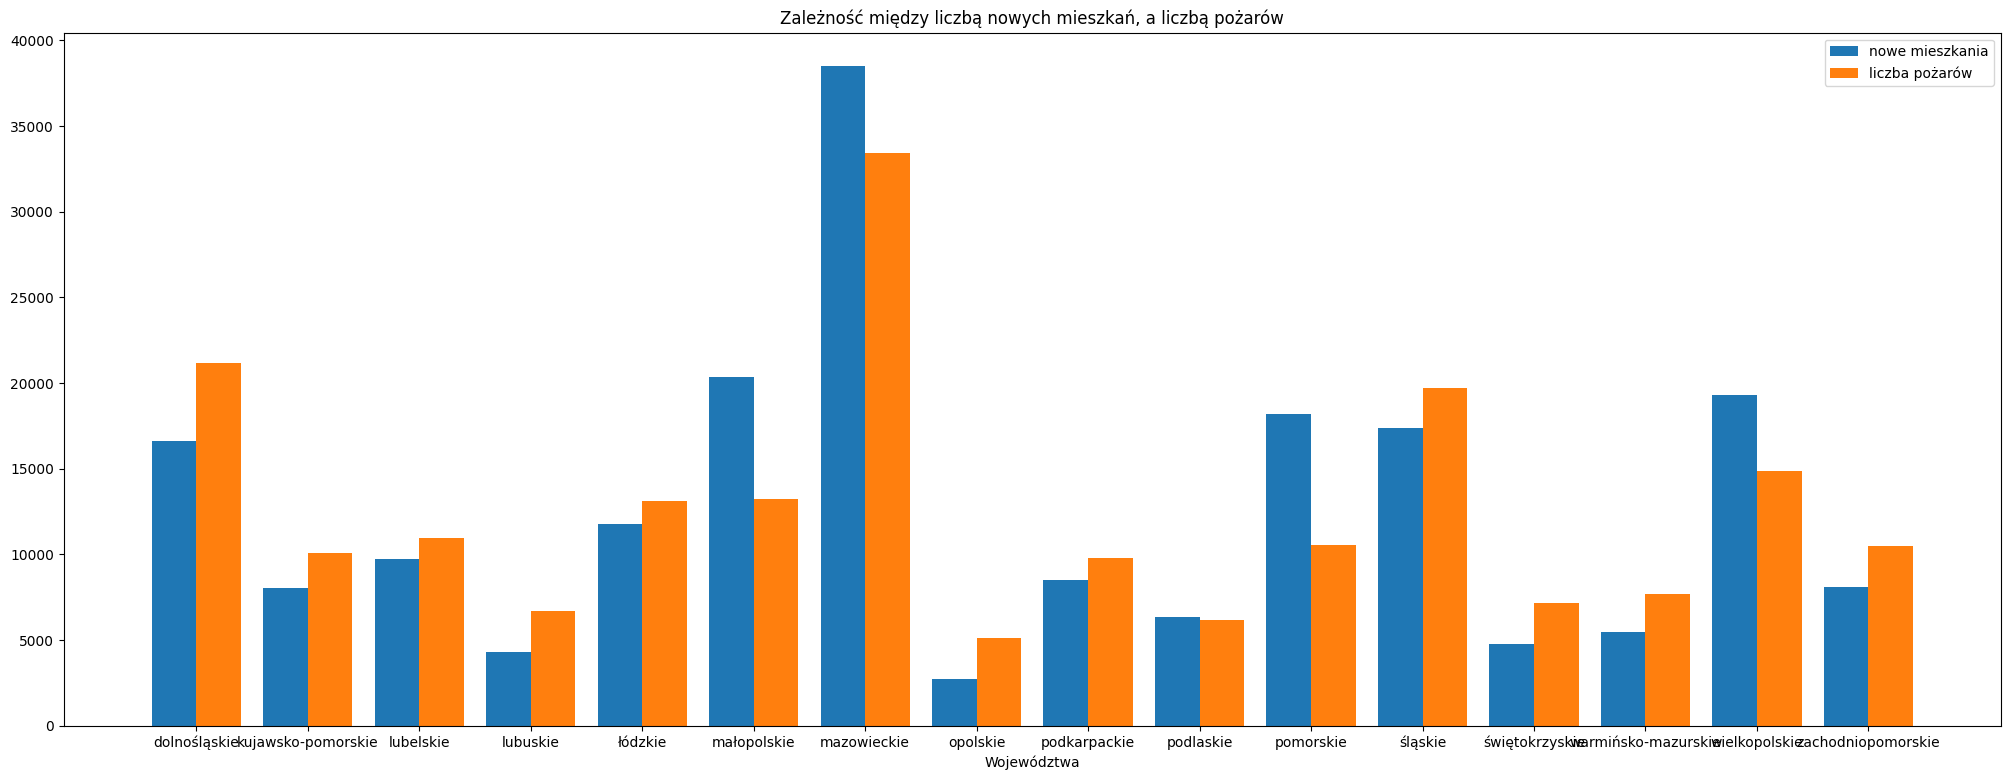

In [41]:
miesz_pozar = pd.merge(mieszk, pozary_grup_woj, on = "Województwo")
pl.barplot_dwa(miesz_pozar.nowe_mieszkania_2024, miesz_pozar["Pożary rok 2024"], miesz_pozar.Województwo, os ="Województwa", 
            tytul = "Zależność między liczbą nowych mieszkań, a liczbą pożarów", legenda = ["nowe mieszkania", "liczba pożarów"])

Wykres ukazuje duże podobieństwo w wartościach, a liczba pożarów rośnie wraz z liczbą nowych mieszkań, ale istnieją czynniki mogące zaburzać relacje między danymi. Przykładem jest mniejsza awaryjność instalacji gazowych i lepsza ochrona przeciwpożarowa w nowych budynkach. Można przypuszczać, że widzimy to na wykresie, ponieważ dla wysokich par słupków głównie wyższe z pary są niebieskie, a dla niskich jest przeciwnie.

Z jednej strony możemy się spodziewać, że im więcej nowych mieszkań, to jak wcześniej wspominaliśmy gęstsza zabudowa i więcej pożarów z drugiej strony lepsza ochrona przeciwpożarowa budynków może utrzymać ich liczbę na podobnym poziommie przez przeprowadzki do nowych mieszkań i rzadkie przypadki w nowych mieszkaniach. Sprawdźmy czy ta statystyka lepiej liniowo rzutuje na liczbę pożarów od liczby ludności.

In [22]:
miesz_pozar[['nowe_mieszkania_2024', "Pożary rok 2024"]].corr()

,nowe_mieszkania_2024,Pożary rok 2024
nowe_mieszkania_2024,1.00000,0.91525
Pożary rok 2024,0.91525,1.00000


Korelacja w tym przypadku jest nieco mniejsza. Mimo to urbanistyka i budownictwo są bardzo ważnymi sektorami jeśli chodzi o zapobieganie pożarom, czego wyraz mamy w współczynniku korelacji większym od $0.9$.

# Profiling

!["wykres czasów wykonywania"](profiler_stat/profiler_bottlenecks.png)

Na fragmencie wykresu czasów wykonywania widzimy, że najwięcej czasu zajmowały funkcje związane z rysowaniem wykresów (plot_barplots 70%) oraz z ładowaniemm danych - ramek z excela: (read_data_from_folder ok.16%) 